In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


__Getting data__

In [2]:
stock = "RR.L.csv"
train = pd.read_csv("../data/train/" + stock).set_index("Date")
validation = pd.read_csv("../data/validation/" + stock).set_index("Date")
test = pd.read_csv("../data/test/" + stock).set_index("Date")
train = pd.concat([train, validation], axis = 0)
train

,Open,High,Low,Close,Adj Close,Volume,Change[%]
Date,,,,,,,
2017-01-03,0.482997,0.479080,0.484905,0.470506,0.452145,0.034897,0.000000
2017-01-04,0.482565,0.471923,0.477626,0.468391,0.450099,0.033528,-0.373130
2017-01-05,0.472647,0.462661,0.457500,0.444714,0.427189,0.116681,-4.194755
2017-01-06,0.457122,0.452137,0.457928,0.454016,0.436190,0.067813,1.720118
2017-01-09,0.464884,0.461028,0.465208,0.462895,0.444781,0.050291,1.614118
...,...,...,...,...,...,...,...
2024-01-31,0.672262,0.658226,0.664609,0.646145,0.646145,0.069847,-1.921196
2024-02-01,0.656177,0.653564,0.654876,0.640231,0.640231,0.199965,-0.796821
2024-02-02,0.664471,0.665096,0.665358,0.668323,0.668323,0.352898,3.815269


__Date Embedding and cyclical transformation__

In [3]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [4]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

In [5]:
'''date = train.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)
train = train.join(date)

date = validation.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)
validation = validation.join(date)

date = test.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)
test = test.join(date)'''

'date = train.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)\ntrain = train.join(date)\n\ndate = validation.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)\nvalidation = validation.join(date)\n\ndate = test.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)\ntest = test.join(date)'

__Creating data loader__

In [6]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

xTrain, yTrain = createSequence(train, train["Close"], 2, 1)
xValid, yValid = createSequence(validation, validation["Close"], 2, 1)
xTest, yTest = createSequence(test, test["Close"], 2, 1)

__Model__

In [7]:
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xValidation = np.array(xValid)
yValidation = np.array(yValid)
xTest = np.array(xTest)
yTest = np.array(yTest)

num_samples, num_days, num_features = xTrain.shape
xTrain_flattened = xTrain.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xValidation.shape
xValidation_flattened = xValidation.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xTest.shape
xTest_flattened = xTest.reshape(num_samples, num_days * num_features)

In [8]:
svr = SVR(kernel='linear', degree=10, C=10.0, epsilon=1e-2, max_iter=-1, tol = 1e-2)
svrMultiOutput = MultiOutputRegressor(svr)
svrMultiOutput.fit(xTrain_flattened, yTrain)
pickle.dump(svrMultiOutput, open("../models/svr_params.pickle", "wb"))

# Load the parameters from file
#svrMultiOutput = pickle.load(open("../models/svr_params.pickle", "rb"))


__Train results__

Total Mean Squared Error: 0.00013609993486497605
Total Mean Absolute Error: 0.00798782704302708


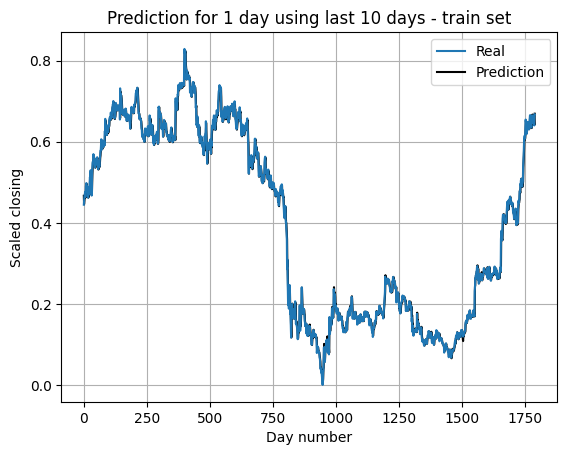

In [9]:
# Make predictions
y_pred = svrMultiOutput.predict(xTrain_flattened)

# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTrain, y_pred)
print(f'Total Mean Squared Error: {mse_total}')

mae_total = mean_absolute_error(yTrain, y_pred)
print(f'Total Mean Absolute Error: {mae_total}')

set = 5*2
real = np.concatenate(yTrain[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()



__Test results__

In [10]:
# Make predictions
y_pred = svrMultiOutput.predict(xTest_flattened)

# Print the shape of predictions to verify
print(y_pred.shape)  # Should be (num_samples, prediction horizont)

(72, 1)


In [11]:
# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTest, y_pred)
print(f'Total Mean Squared Error: {mse_total}')

mae_total = mean_absolute_error(yTest, y_pred)
print(f'Total Mean Absolute Error: {mae_total}')

Total Mean Squared Error: 0.00034965456364572316
Total Mean Absolute Error: 0.014572137964404378


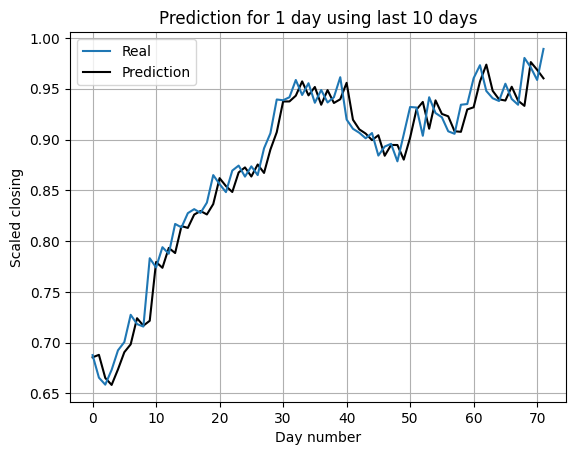

In [14]:
set = 5*2
real = np.concatenate(yTest[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days")
plt.show()